---

Dynamic Nelson-Siegel (DNS) with Kalman Filter

---

- Nelson-Siegel (NS) model is a popular approach for modeling the yield curve. 

- The model represents the yield curve as a function of three factors: level, slope, and curvature. 

- The dynamic version of the Nelson-Siegel model allows these factors to evolve over time, making it suitable for capturing changes in the yield curve.

$$
    y_t(\tau) = \beta_{0,t} + \beta_{1,t} \left( \frac{1 - e^{-\lambda \tau}}{\lambda \tau} \right) + \beta_{2,t} \left( \frac{1 - e^{-\lambda \tau}}{\lambda \tau} - e^{-\lambda \tau} \right)
$$

- The NS parameters 
    - $ \beta_{0,t} $: level (long term). This is the limit of the yield curve as $\tau \to \infty$.
    - $ \beta_{1,t} $: slope (short term). It controls the short-end of the yield curve relative to the long-end.
    - $ \beta_{2,t} $: curvature (medium term). This is the curvature of the yield curve. Adds "hump-shaped" deviations in the medium term.

    are not directly observable. They are typically inferred from the cross-section of yields at each date $t$

- OLS gives an independent estimate of the parameters at each date, but does not take into account the time series dynamics of the parameters.

- Instead, Kalman filter treats as hidden states in a state-space model, that evolve smoothly over time.
It uses all the available information.

- Consequences: 
    - Less noisy estimates. Filtered and smoothed.
    - Better behavior during missing data.
    - More robust to outliers.
    - Can be used for forecasting.

## Imports

In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from stochastic.yield_curve import nelson_siegel, nelson_siegel_loadings
from scipy.optimize import curve_fit

sns.set_theme("talk")
mpl.rcParams["figure.figsize"] = (8, 6)

## Nelson-Siegel model

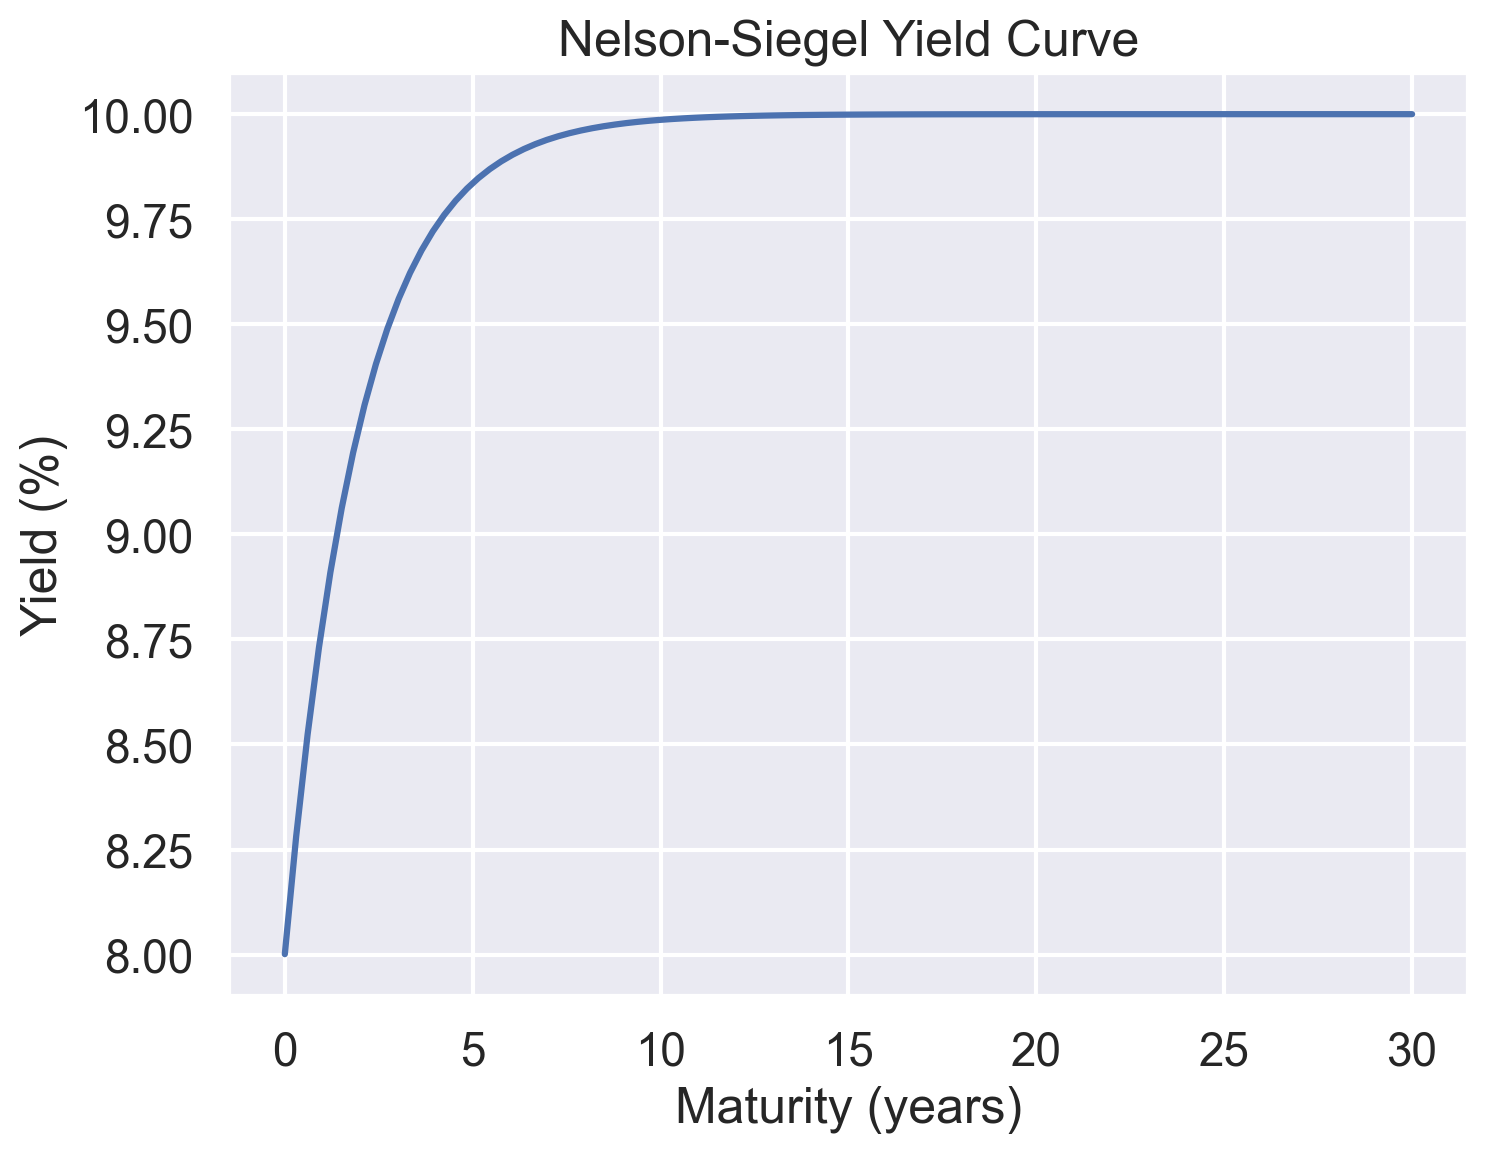

In [4]:
beta_0 = 0.1  # long-term factor
beta_1 = -0.02  # short-term factor
beta_2 = 0.02  # medium-term factor
lbd = 0.5  # decay factor

taus = np.linspace(1e-3, 30, 100)

fig, ax = plt.subplots()
ax.plot(taus, 100.0 * nelson_siegel(taus, beta_0, beta_1, beta_2, lbd))
ax.set_xlabel("Maturity (years)")
ax.set_ylabel("Yield (%)")
ax.set_title("Nelson-Siegel Yield Curve")
plt.show()

Nelson-Siegel widget to visualize the effect of parameters

In [4]:
from ipywidgets import interact
import ipywidgets as widgets


@interact(
    lbd=widgets.FloatSlider(
        value=0.5, min=0.1, max=3.0, step=0.1, description=r"$\lambda$"
    ),
    beta_0=widgets.FloatSlider(
        value=0.1, min=0.1, max=1, step=0.1, description=r"$\beta_0$"
    ),
    beta_1=widgets.FloatSlider(
        value=-0.02, min=-1.0, max=1.0, step=0.1, description=r"$\beta_1$"
    ),
    beta_2=widgets.FloatSlider(
        value=0.02, min=1e-2, max=1, step=0.1, description=r"$\beta_2$"
    ),
)
def plot(lbd, beta_0, beta_1, beta_2):
    fig, ax = plt.subplots()
    ax.plot(taus, 100.0 * nelson_siegel(taus, beta_0, beta_1, beta_2, lbd))
    ax.set_xlabel("Maturity (years)")
    ax.set_ylabel("Yield (%)")
    ax.set_title("Nelson-Siegel Yield Curve")
    plt.show()

interactive(children=(FloatSlider(value=0.5, description='$\\lambda$', max=3.0, min=0.1), FloatSlider(value=0.…

Load historical yield curve data (from FRED)

In [5]:
df_yields = pd.read_csv("data/yields.csv", index_col=0, parse_dates=True).dropna()
df_yields.index = pd.to_datetime(df_yields.index, format="%Y-%m-%d")
df_yields /= 100.0  # convert to decimal

In [6]:
tickers = df_yields.columns.tolist()
print("Available maturities (years):", tickers)

Available maturities (years): ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']


Create time to maturities associated with the yield curve data

In [7]:
time_to_mats = np.array([1 / 12, 3 / 12, 6 / 12, 1, 2, 3, 5, 7, 10, 20, 30])
list_dates = df_yields.index.tolist()

In [8]:
df_yields.head()

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
DATE,,,,,,,,,,,
2010-01-04,0.0005,0.0008,0.0018,0.0045,0.0109,0.0166,0.0265,0.0336,0.0385,0.0460,0.0465
2010-01-05,0.0003,0.0007,0.0017,0.0041,0.0101,0.0157,0.0256,0.0328,0.0377,0.0454,0.0459
2010-01-06,0.0003,0.0006,0.0015,0.0040,0.0101,0.0160,0.0260,0.0333,0.0385,0.0463,0.0470
2010-01-07,0.0002,0.0005,0.0016,0.0040,0.0103,0.0162,0.0262,0.0333,0.0385,0.0462,0.0469
2010-01-08,0.0002,0.0005,0.0015,0.0037,0.0096,0.0156,0.0257,0.0331,0.0383,0.0461,0.0470


In [9]:
df_yields.tail()

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
DATE,,,,,,,,,,,
2025-09-18,0.0420,0.0403,0.0381,0.0361,0.0357,0.0355,0.0367,0.0386,0.0411,0.0468,0.0472
2025-09-19,0.0419,0.0403,0.0381,0.0360,0.0357,0.0356,0.0368,0.0388,0.0414,0.0471,0.0475
2025-09-22,0.0417,0.0400,0.0381,0.0361,0.0361,0.0359,0.0371,0.0390,0.0415,0.0473,0.0477
2025-09-23,0.0416,0.0400,0.0381,0.0361,0.0353,0.0357,0.0368,0.0387,0.0412,0.0470,0.0473
2025-09-24,0.0418,0.0402,0.0382,0.0363,0.0357,0.0360,0.0370,0.0391,0.0416,0.0473,0.0476


Plot yield curve data at a specific date and compare with Nelson-Siegel fit.

We use `scipy.optimize.curve_fit` to get the fit parameters.

In [9]:
date = dt.datetime(2025, 9, 24)
yields_date = 100 * df_yields.loc[date].to_numpy()

In [10]:
p0 = [0.05, 0.01, 0.03, 0.02]  # initial guess for the parameters
fit_params, _ = curve_fit(f=nelson_siegel, xdata=time_to_mats, ydata=yields_date, p0=p0)

In [11]:
tau_ns = np.linspace(1e-3, 30, 100)
ns_fit_date = nelson_siegel(tau_ns, *fit_params)

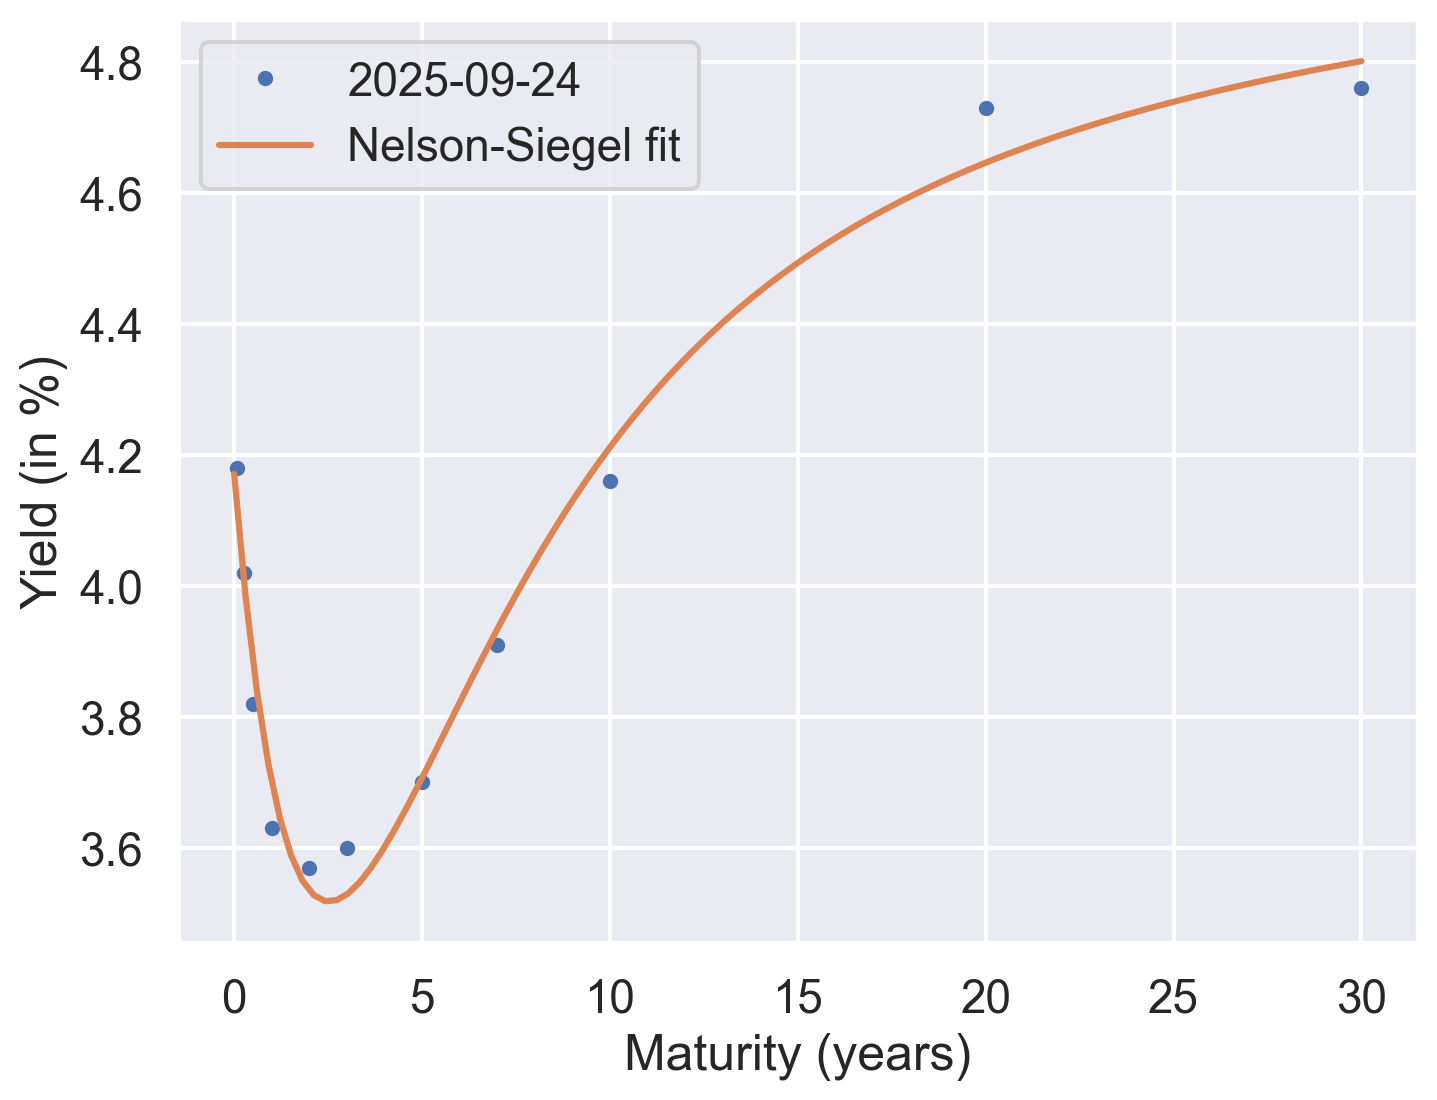

In [12]:
fig, ax = plt.subplots()
ax.plot(time_to_mats, yields_date, ".", label=f"{date.strftime('%Y-%m-%d')}")
ax.plot(tau_ns, ns_fit_date, "-", label="Nelson-Siegel fit")
ax.legend()
ax.set_ylabel("Yield (in %)")
ax.set_xlabel("Maturity (years)")
plt.show()

In [13]:
Y = df_yields.values  # shape (T, M)
Y

array([[0.0005, 0.0008, 0.0018, ..., 0.0385, 0.046 , 0.0465],
       [0.0003, 0.0007, 0.0017, ..., 0.0377, 0.0454, 0.0459],
       [0.0003, 0.0006, 0.0015, ..., 0.0385, 0.0463, 0.047 ],
       ...,
       [0.0417, 0.04  , 0.0381, ..., 0.0415, 0.0473, 0.0477],
       [0.0416, 0.04  , 0.0381, ..., 0.0412, 0.047 , 0.0473],
       [0.0418, 0.0402, 0.0382, ..., 0.0416, 0.0473, 0.0476]],
      shape=(3935, 11))

In [15]:
T, M = Y.shape

**NS Loadings**

For a shape parameter $\lambda > 0$, the NS loadings are given by:

$$
    \ell_0(\tau) = 1, 
    \qquad 
    \ell_1(\tau) = \frac{1 - e^{-\lambda \tau}}{\lambda \tau}, 
    \qquad 
    \ell_2(\tau) = \ell_1(\tau) - e^{-\lambda \tau}
$$

Stack into the $M \times 3$ matrix $\Lambda$:

$$
    \Lambda = 
    \begin{pmatrix}
    \ell_0(\tau_1) & \ell_1(\tau_1) & \ell_2(\tau_1) \\
    \ell_0(\tau_2) & \ell_1(\tau_2) & \ell_2(\tau_2) \\
    \vdots & \vdots & \vdots \\
    \ell_0(\tau_M) & \ell_1(\tau_M) & \ell_2(\tau_M)
    \end{pmatrix} \in \mathbb{R}^{M \times 3}
$$

**Observation equation**

Let the latent factors (level/slope/curvature) at time $t$ be $\beta_t = (\beta_{0,t}, \beta_{1,t}, \beta_{2,t})^\prime \in \mathbb{R}^3$.

$$
    y_t = \Lambda \beta_t + \varepsilon_t, \qquad \varepsilon_t \sim \mathcal{N}(0, R)
$$

**State equation (VAR(1) on the factors)**

$$
    \beta_t = c + A \, \beta_{t-1} + \eta_t,
    \qquad
    \eta_t \sim \mathcal{N}(0, Q)
$$

**Cross-sectional OLS betas per date (Initial state series)**

$$
    \hat{\beta}_t = (\Lambda^\prime \Lambda)^{-1} \Lambda^\prime y_t
$$

In [16]:
lbd = 0.06
L = nelson_siegel_loadings(time_to_mats, lbd)
LtL_inv_Lt = np.linalg.inv(L.T @ L) @ L.T
beta_hat = np.empty((T, 3))

for t in range(T):
    beta_hat[t] = LtL_inv_Lt @ Y[t]

In [17]:
df_beta_hat = pd.DataFrame(
    beta_hat, index=df_yields.index, columns=["beta0", "beta1", "beta2"]
)

In [18]:
df_beta_hat.head()

,beta0,beta1,beta2
DATE,,,
2010-01-04,-0.075404,0.074963,0.286935
2010-01-05,-0.071075,0.070362,0.278071
2010-01-06,-0.071547,0.070687,0.282675
2010-01-07,-0.072977,0.072144,0.284678
2010-01-08,-0.069560,0.068524,0.279428


See fit at last date

In [19]:
date = dt.datetime(2025, 9, 23)  # pick a date

In [20]:
L @ df_beta_hat.loc[date] * 100

array([3.79168872, 3.79111161, 3.79056049, 3.79056017, 3.79474262,
       3.8040953 , 3.83650864, 3.88450464, 3.97960455, 4.41339067,
       4.90323258])

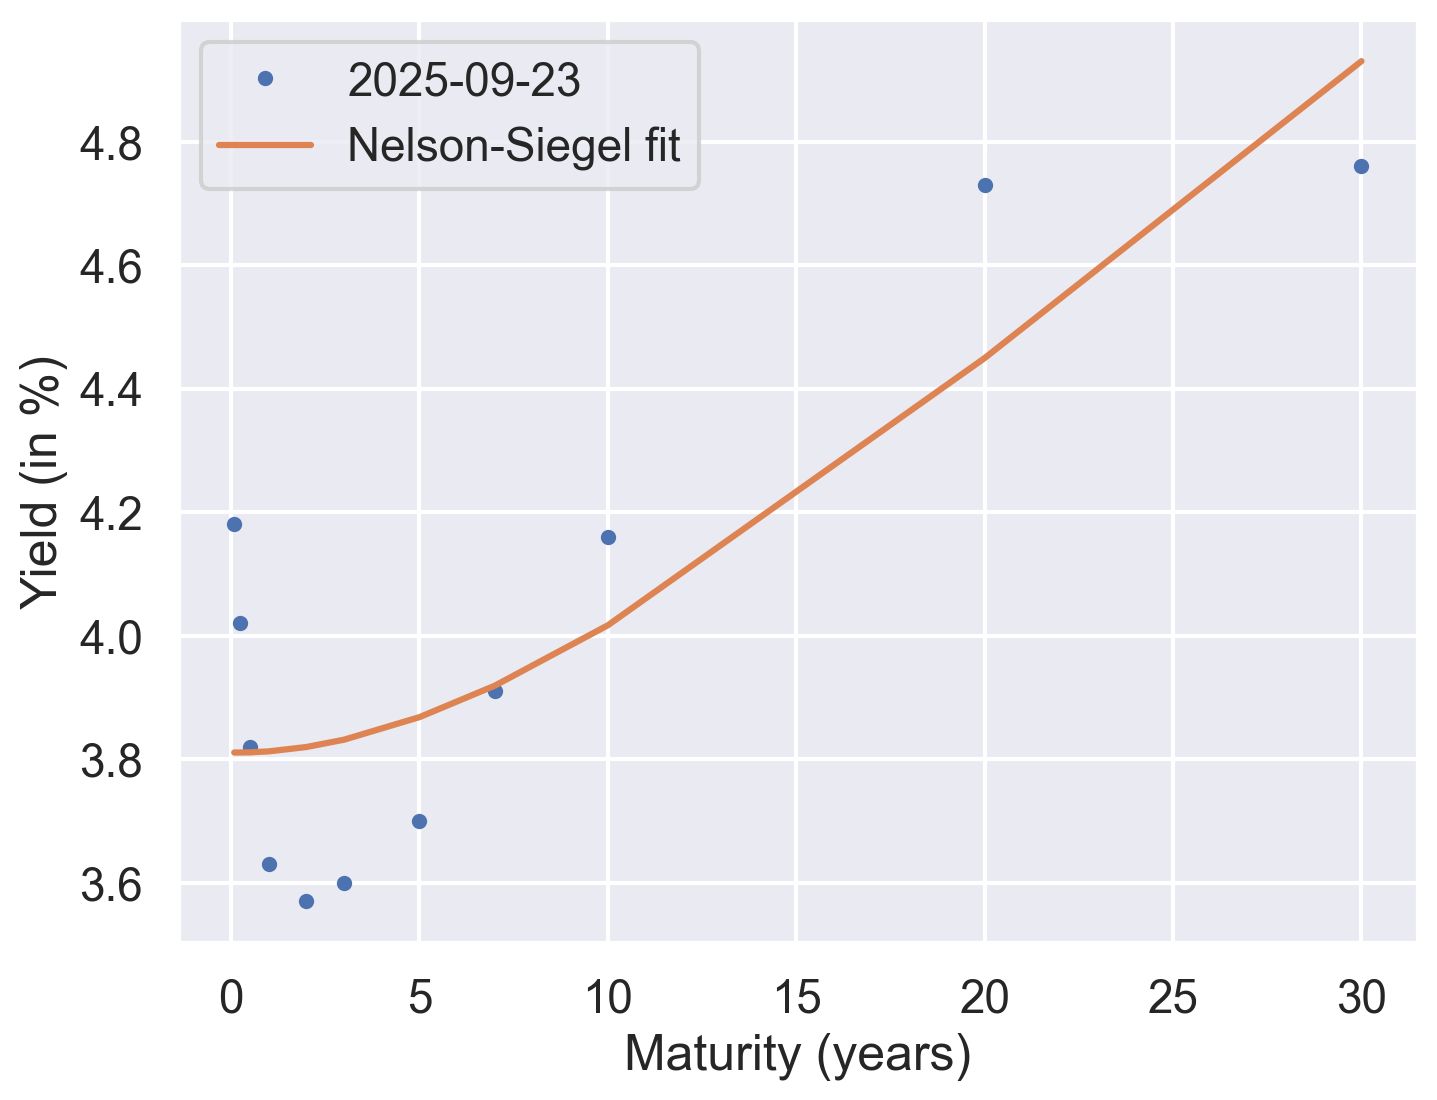

In [21]:
fig, ax = plt.subplots()
ax.plot(time_to_mats, yields_date, ".", label=f"{date.strftime('%Y-%m-%d')}")
ax.plot(time_to_mats, L @ df_beta_hat.iloc[-1] * 100, "-", label="Nelson-Siegel fit")
ax.legend()
ax.set_ylabel("Yield (in %)")
ax.set_xlabel("Maturity (years)")
plt.show()

Observation noise $R$ (diagonal starter: uniform noise across maturities)

In [22]:
resids = []
for t in range(T):
    resids.append(Y[t] - L @ beta_hat[t])
resids = np.array(resids)  # (T, M)
R = np.diag(resids.var(axis=0))  # (M,M) diagonal

In [23]:
R.shape

(11, 11)

Estimate VAR(1) on the OLS betas

In [24]:
B = beta_hat[1:]  # (T-1, 3)
B_lag = beta_hat[:-1]  # (T-1, 3)

# OLS for multivariate regression: B = [1, B_lag] @ Theta + noise
X = np.hstack([np.ones((T - 1, 1)), B_lag])  # (T-1, 1+3)
Theta = np.linalg.lstsq(X, B, rcond=None)[0]  # (1+3, 3)

c = Theta[0]  # (3,)
A = Theta[1:].T  # (3,3); transpose to make A @ beta_{t-1}

# innovations and covariance Q
eta = B - X @ Theta  # (T-1, 3)
Q = np.cov(eta.T, bias=False)  # (3,3)

In [25]:
Q.shape

(3, 3)

## Build Kalman filter matrices (predict-update steps)

Let $\beta_{t|t-1}$ and $P_{t|t-1}$ be the predicted state and covariance 
at time $t$ given observations up to time $t-1$. Then:

**Predict**:

$$
    \beta_{t|t-1} = c + A \, \beta_{t-1 | t-1} \qquad P_{t|t-1} = A P_{t-1 | t-1} A^\prime + Q
$$

**Innovation and gain**:

$$
    \nu_t = y_t - \Lambda \beta_{t|t-1} \qquad S_t = \Lambda P_{t|t-1} \Lambda^\prime + R
    \qquad K_t = P_{t|t-1} \Lambda^\prime S_t^{-1}
$$

**Update**:

$$
    \beta_{t|t} = \beta_{t|t-1} + K_t \nu_t \qquad P_{t|t} = (I - K_t \Lambda) P_{t|t-1}
$$

In [26]:
I3 = np.eye(3)

# init (use first OLS beta and identity covariance for P)
beta_filt = np.zeros((T, 3))
P_filt = np.zeros((T, 3, 3))
beta_prev = beta_hat[0]
P_prev = np.eye(3)

for t in range(T):
    # predict
    beta_pred = c + A @ beta_prev
    P_pred = A @ P_prev @ A.T + Q

    # update
    y_pred = L @ beta_pred
    S = L @ P_pred @ L.T + R  # (M,M)
    K = P_pred @ L.T @ np.linalg.inv(S)  # (3,M)  Kalman gain
    innov = Y[t] - y_pred  # innovation

    beta_new = beta_pred + K @ innov
    P_new = (I3 - K @ L) @ P_pred
    beta_filt[t] = beta_new
    P_filt[t] = P_new
    beta_prev, P_prev = beta_new, P_new

In [27]:
df_beta_filt = pd.DataFrame(
    beta_filt, index=df_yields.index, columns=["beta0", "beta1", "beta2"]
)

**Rauch-Tung-Striebel (RTS) smoother (optional)**

Define the smoother gain (backward, $t=T-1,\ldots,0$):

$$
    J_t = P_{t|t} A^T P_{t+1|t}^{-1}
$$

Then, the smoothed state means and covariances are given by:

$$
\begin{aligned}
    \beta_{t|T} &= \beta_{t|t} + J_t (\beta_{t+1|T} - \beta_{t+1|t}) \\
    P_{t|T}     &= P_{t|t} + J_t (P_{t+1|T} - P_{t+1|t}) J_t^T
\end{aligned}
$$

In [28]:
beta_smooth = beta_filt.copy()
P_smooth = P_filt.copy()

# need predicted states/covariances; recompute and store during filtering
beta_pred_list, P_pred_list = [], []
beta_prev, P_prev = beta_hat[0], np.eye(3)
for t in range(T):
    beta_pred = c + A @ beta_prev
    P_pred = A @ P_prev @ A.T + Q
    beta_pred_list.append(beta_pred)
    P_pred_list.append(P_pred)

    # update
    y_pred = L @ beta_pred
    S = L @ P_pred @ L.T + R
    K = P_pred @ L.T @ np.linalg.inv(S)
    innov = Y[t] - y_pred
    beta_new = beta_pred + K @ innov
    P_new = (I3 - K @ L) @ P_pred
    beta_prev, P_prev = beta_new, P_new

beta_pred_arr = np.array(beta_pred_list)  # (T,3)
P_pred_arr = np.array(P_pred_list)  # (T,3,3)

# RTS backward pass
for t in range(T - 2, -1, -1):
    J = P_filt[t] @ A.T @ np.linalg.inv(P_pred_arr[t + 1])  # smoother gain
    beta_smooth[t] = beta_filt[t] + J @ (beta_smooth[t + 1] - beta_pred_arr[t + 1])
    P_smooth[t] = P_filt[t] + J @ (P_smooth[t + 1] - P_pred_arr[t + 1]) @ J.T

df_beta_smooth = pd.DataFrame(
    beta_smooth, index=df_yields.index, columns=["beta0", "beta1", "beta2"]
)

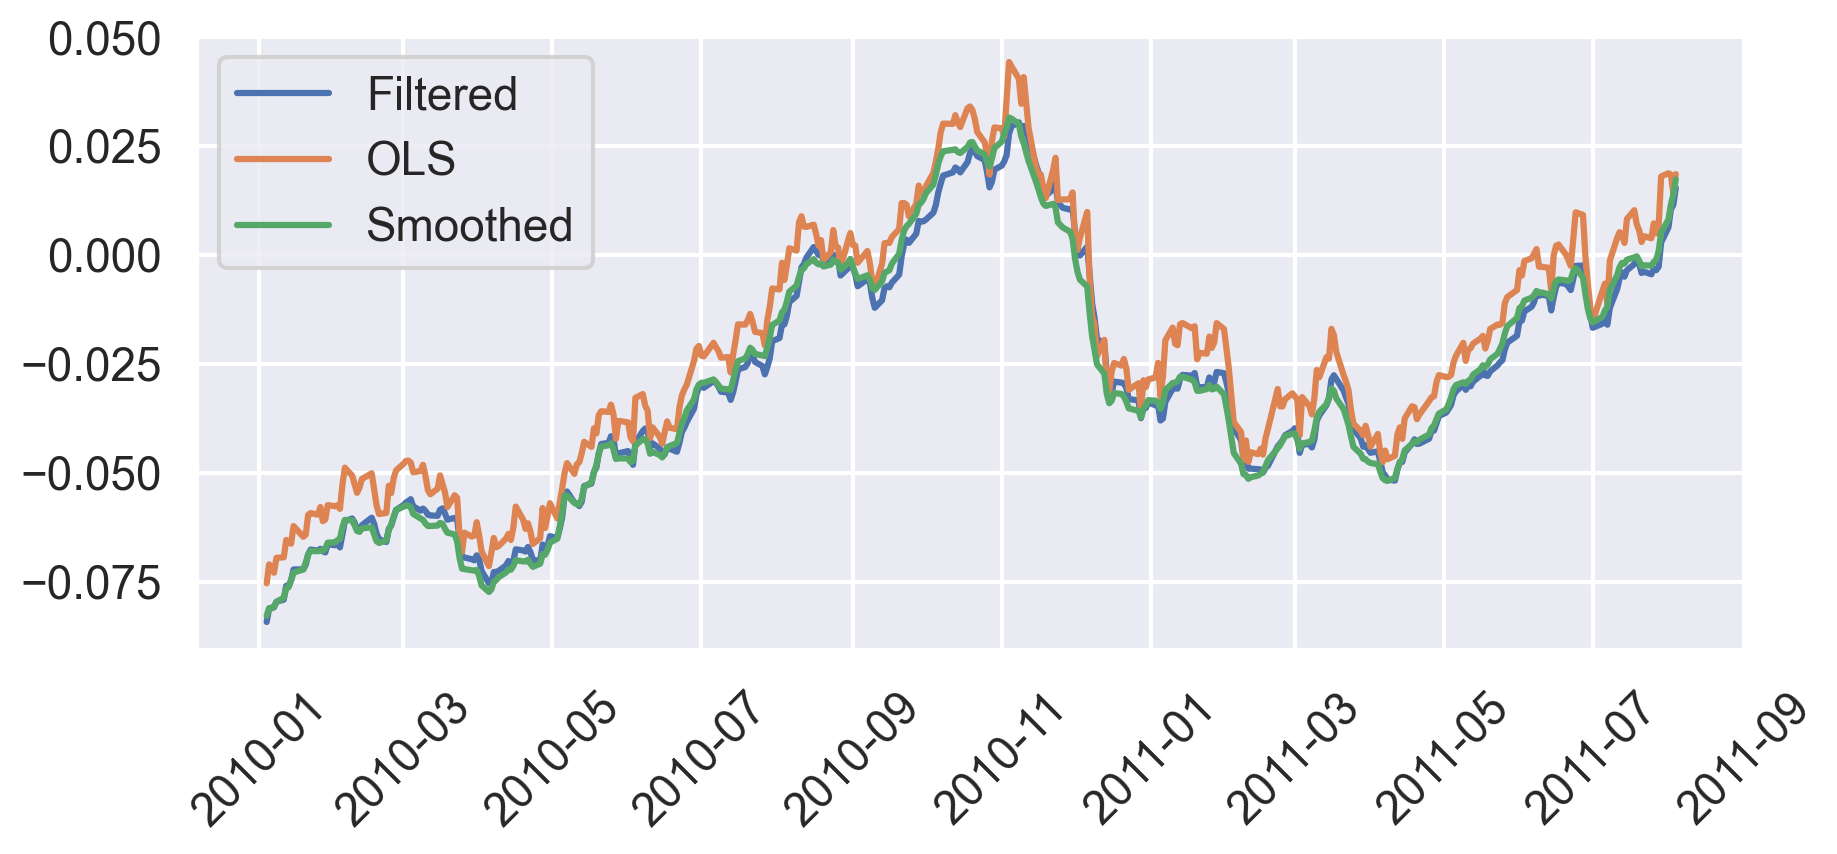

In [29]:
sub_dates = list_dates[:400]

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(
    sub_dates, df_beta_filt.loc[sub_dates]["beta0"].to_numpy(), "-", label="Filtered"
)
ax.plot(sub_dates, df_beta_hat.loc[sub_dates]["beta0"].to_numpy(), "-", label="OLS")
ax.plot(
    sub_dates, df_beta_smooth.loc[sub_dates]["beta0"].to_numpy(), "-", label="Smoothed"
)
ax.legend()
ax.tick_params(axis="x", rotation=45)
plt.show()

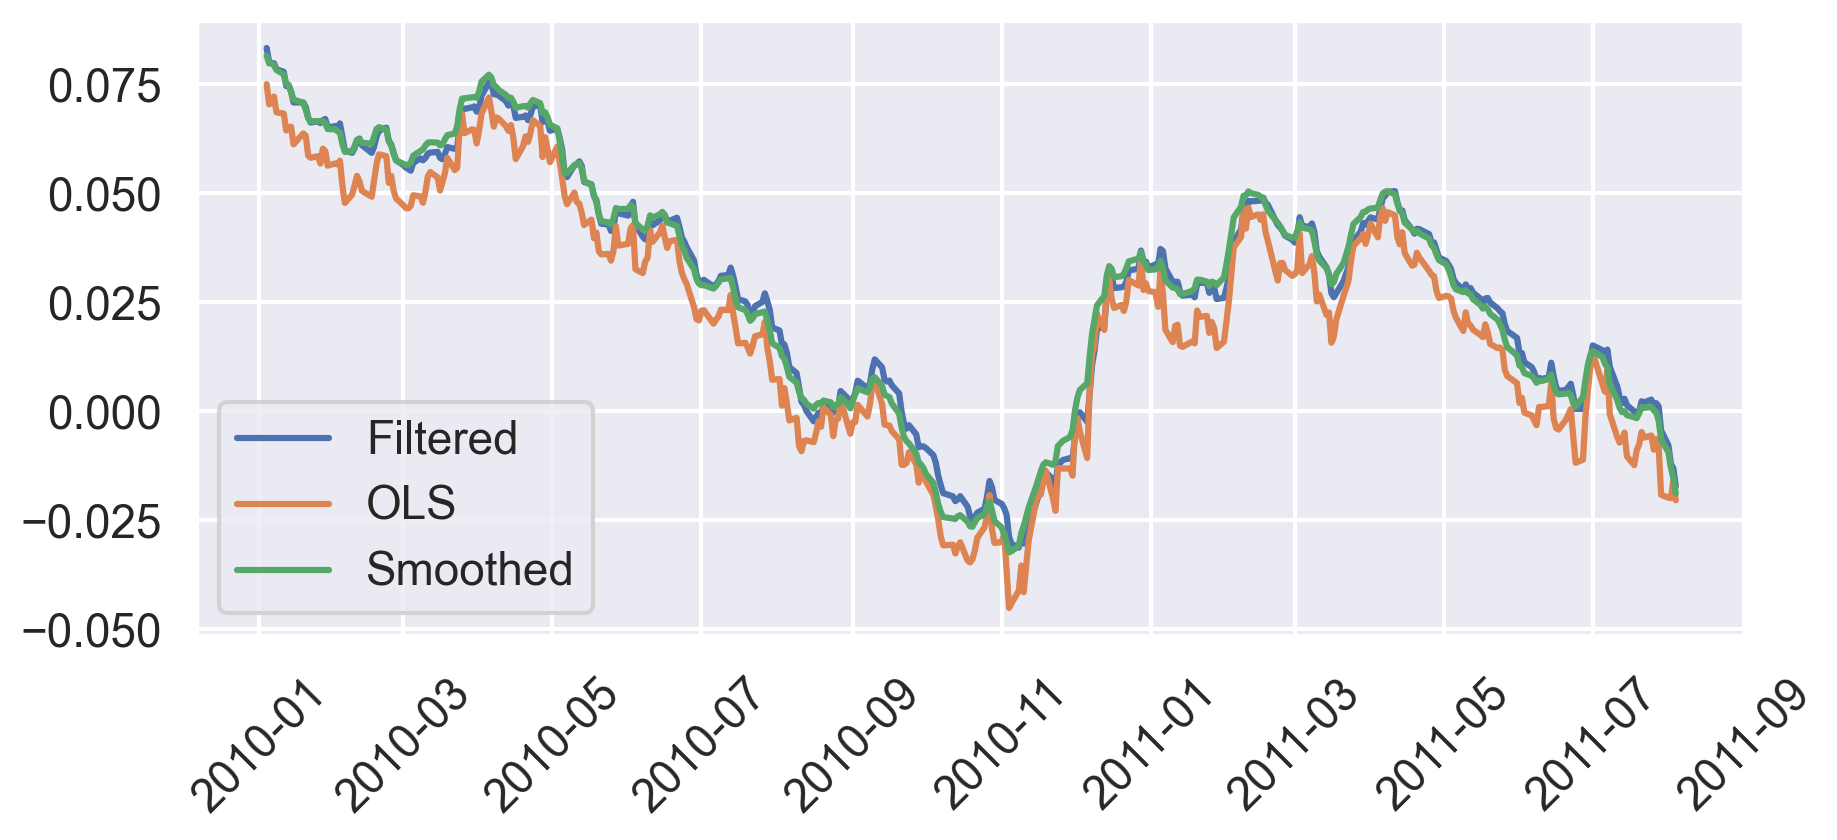

In [30]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    sub_dates, df_beta_filt.loc[sub_dates]["beta1"].to_numpy(), "-", label="Filtered"
)
ax.plot(sub_dates, df_beta_hat.loc[sub_dates]["beta1"].to_numpy(), "-", label="OLS")
ax.plot(
    sub_dates, df_beta_smooth.loc[sub_dates]["beta1"].to_numpy(), "-", label="Smoothed"
)
ax.legend()
ax.tick_params(axis="x", rotation=45)
plt.show()

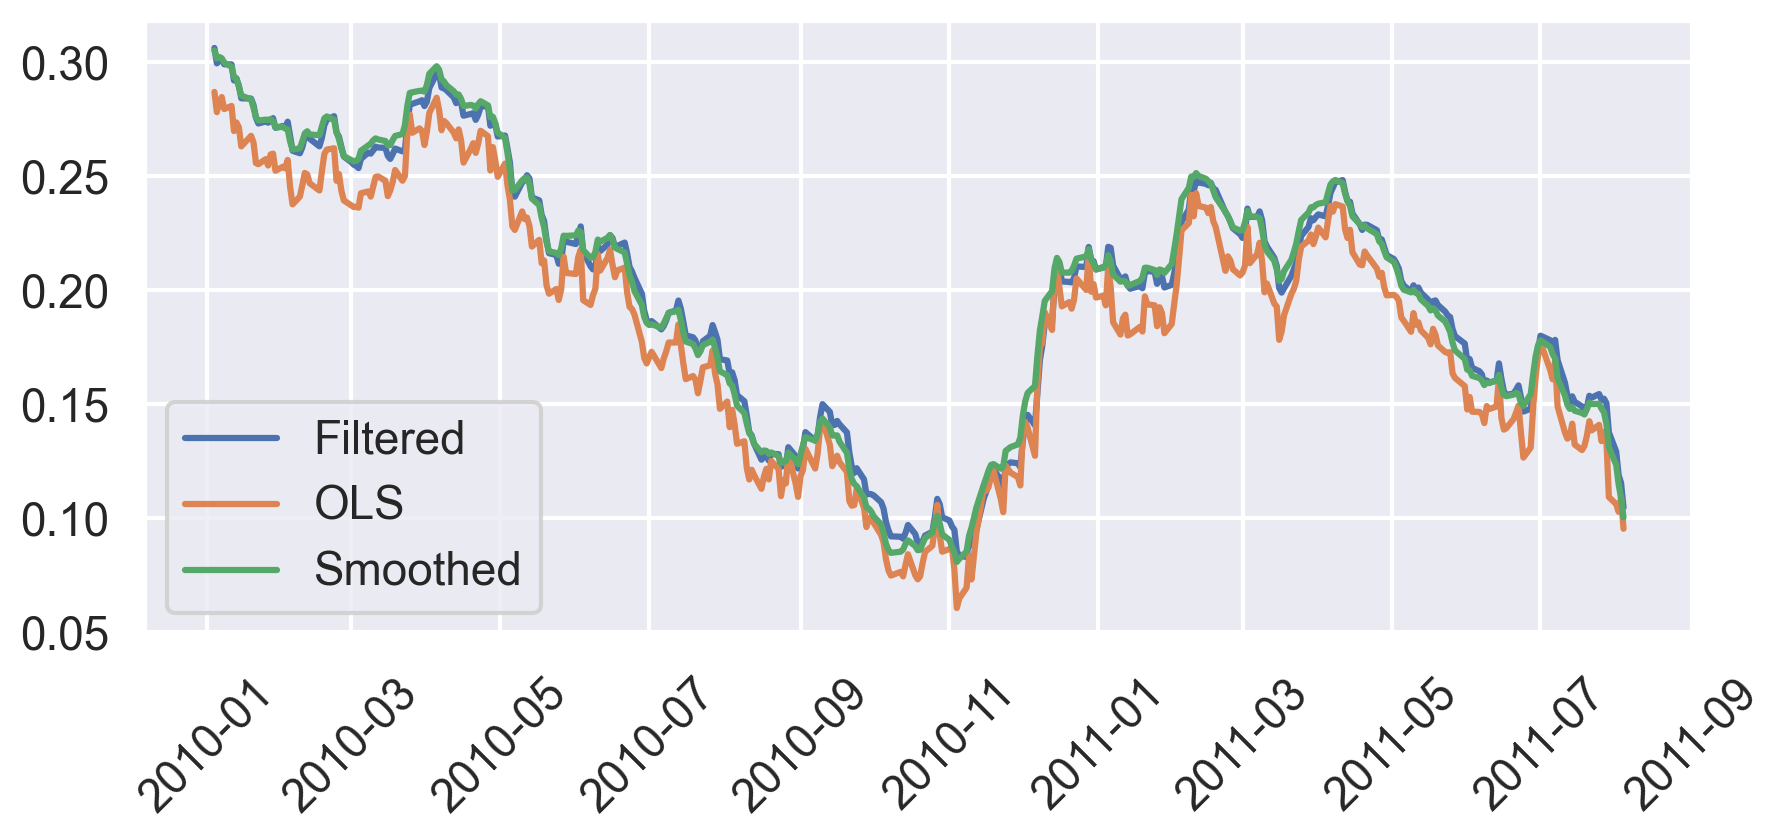

In [31]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    sub_dates, df_beta_filt.loc[sub_dates]["beta2"].to_numpy(), "-", label="Filtered"
)
ax.plot(sub_dates, df_beta_hat.loc[sub_dates]["beta2"].to_numpy(), "-", label="OLS")
ax.plot(
    sub_dates, df_beta_smooth.loc[sub_dates]["beta2"].to_numpy(), "-", label="Smoothed"
)
ax.legend()
ax.tick_params(axis="x", rotation=45)
plt.show()